## Setup

In [1]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import numpy as np
import pandas as pd
import random
# import cudf as pd
import tensorflow as tf
import isuelogit as isl
import glob

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/Library/CloudStorage/OneDrive-Personal/data-science/github/gisuelogit


In [3]:
# Internal modules
from src.gisuelogit.models import UtilityParameters, BPRParameters, ODParameters, GISUELOGIT, NGD, compute_rr
from src.gisuelogit.visualizations import plot_predictive_performance, plot_convergence_estimates, plot_top_od_flows_periods, plot_utility_parameters_periods
from src.gisuelogit.networks import load_k_shortest_paths, read_paths, build_fresno_network, \
    Equilibrator, sparsify_OD, ColumnGenerator, read_OD
from src.gisuelogit.etl import get_design_tensor, get_y_tensor, data_curation, temporal_split, add_period_id
from src.gisuelogit.descriptive_statistics import mse, btcg_mse, mnrmse, nrmse

In [4]:
# Seed for reproducibility
_SEED = 2022
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

## Build Fresno network

In [5]:
fresno_network = build_fresno_network()

## Read OD matrix

In [6]:
read_OD(network=fresno_network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs


## Read paths

In [7]:
#read_paths(network=fresno_network, update_incidence_matrices=True, filename='paths-fresno.csv')
read_paths(network=fresno_network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

# For quick testing
# Q = fresno_network.load_OD(sparsify_OD(fresno_network.Q, prop_od_pairs=0.99))
# load_k_shortest_paths(network=fresno_network, k=2, update_incidence_matrices=True)

18289 paths were read in 40.3[s]              

18289 paths were loaded in the network

Updating incidence matrices

Matrix D (2413, 18289) generated in 43.3[s]               

Matrix M (6970, 18289) generated in 17.1[s]               

Matrix C (18289, 18289) generated in 9.5[s]               



## Read spatiotemporal data

In [8]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*fresno-link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Select data from Tuesday to Thursday
df = df[df['date'].dt.dayofweek.between(1, 3)]
# df = df[df['date'].dt.year == 2019]

df['period'] = df['date'].astype(str) + '-' + df['hour'].astype(str)
df['period'] = df.period.map(hash)

df = add_period_id(df, period_feature='hour')

## Data curation

In [9]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

df = data_curation(df)

## Utility function

In [10]:
# features_Z = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']
features_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

utility_parameters = UtilityParameters(features_Y=['tt'],
                                       features_Z=features_Z,
                                       initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                       'fixed_effect': np.zeros_like(fresno_network.links)},
                                       signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                              'bus_stops': '-', 'intersections': '-'},
                                       trainables={'psc_factor': False, 'fixed_effect': False},
                                       )

utility_parameters.constant_initializer(0)

## Data processing

In [11]:
n_links = len(fresno_network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [12]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,7317.000000,125476.000000,108678.000000,125476.000000,125476.000000
mean,1849.511439,0.003413,0.003842,0.201464,0.052403
std,793.468215,0.004365,0.004615,0.231739,0.093795
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,1341.000000,0.000000,0.000000,0.000000,0.000000
50%,1759.200000,0.002508,0.002911,0.151000,0.010000
75%,2266.200000,0.004697,0.005569,0.286000,0.069000
max,4807.000000,0.070155,0.057848,4.605000,1.484000


In [13]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,17893.000000,306451.000000,273261.000000,306451.000000,306451.000000
mean,1617.909635,0.003376,0.003623,0.198681,0.024408
std,752.284019,0.004322,0.004290,0.226728,0.040023
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1117.000000,0.000000,0.000000,0.000000,0.000000
50%,1537.000000,0.002491,0.002765,0.150000,0.010000
75%,1994.000000,0.004578,0.005131,0.273000,0.033000
max,4766.000000,0.070155,0.054574,3.775000,0.773000


In [14]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in fresno_network.links:
    fresno_network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==str(link.key)])

In [15]:
# Select only dates used for previous paper

# df = df.query('date == "2019-10-01"  | date == "2020-10-06"')
# df = df.query('date == "2019-10-01"')
# df = df.query('hour == 16')
# df = df.query('hour == 17')
#df = df.query('hour == 16 | hour == 17')

## EDA

### Cross sectional

In [16]:
eda_df = df.copy()
eda_df['date'] = eda_df['date'].astype(str)

# Transform to monthly income
eda_df['median_inc'] = eda_df['median_inc']/12

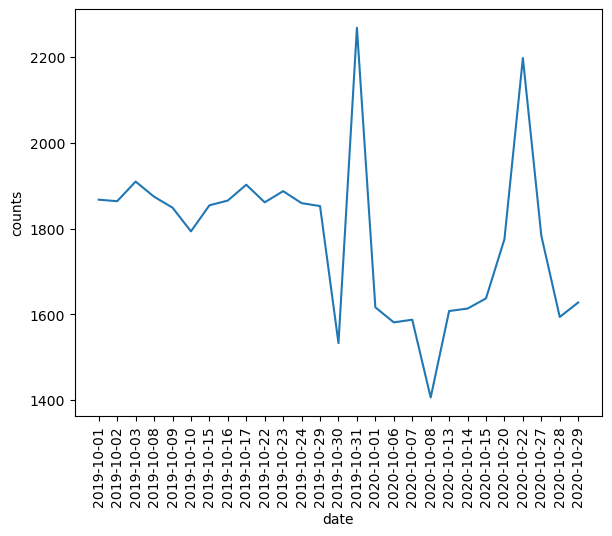

In [17]:
sns.lineplot(x= 'date', y = 'counts', data =eda_df.groupby('date')[['counts']].mean().reset_index())
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

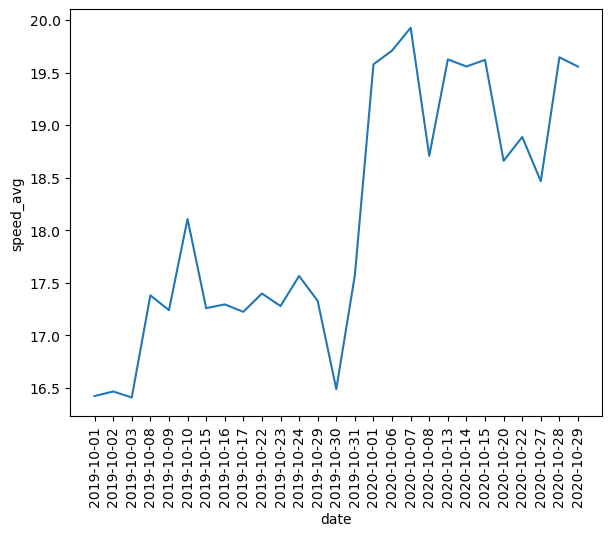

In [18]:
sns.lineplot(x= 'date', y = 'speed_avg', data =eda_df.groupby('date')[['speed_avg']].mean().reset_index())
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

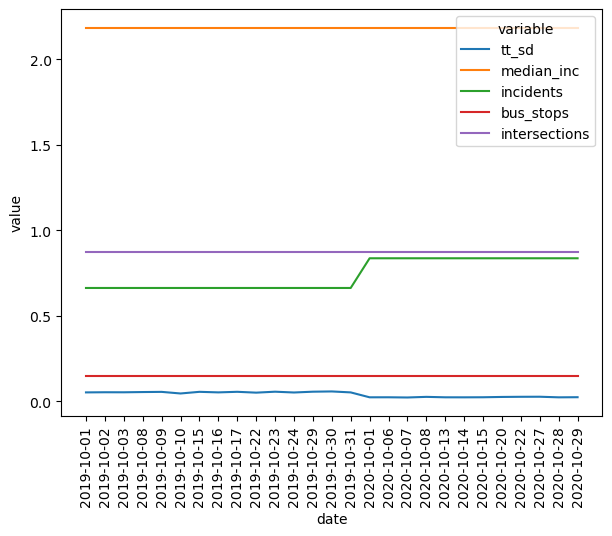

In [19]:
sns.lineplot(x= 'date', y = 'value', hue = 'variable', data =pd.melt(eda_df.groupby('date')[features_Z].mean().reset_index(),id_vars= ['date']))
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

### By hour of day

In [20]:
link_keys = eda_df[(eda_df.counts>0) & (eda_df.speed_avg>0)].link_key.unique()
link_keys = link_keys[0:10]

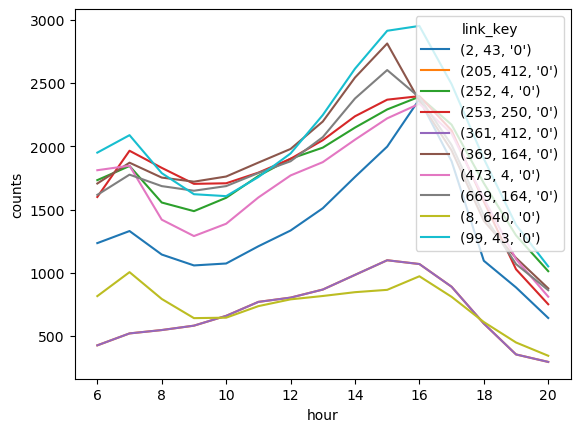

In [21]:
sns.lineplot(x= 'hour', y = 'counts', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['counts']].mean().reset_index())

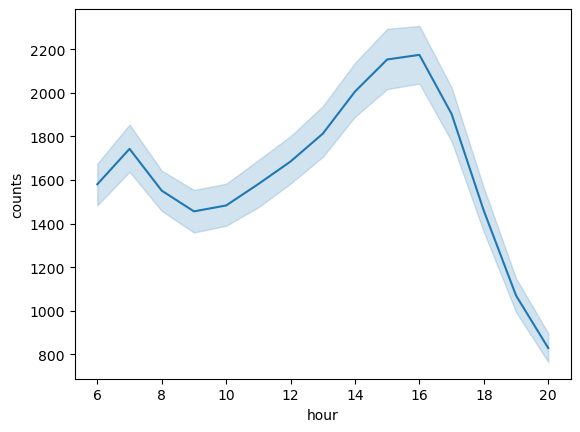

In [22]:
sns.lineplot(x= 'hour', y = 'counts', data =eda_df.groupby(['hour','link_key'])[['counts']].mean().reset_index())
plt.show()

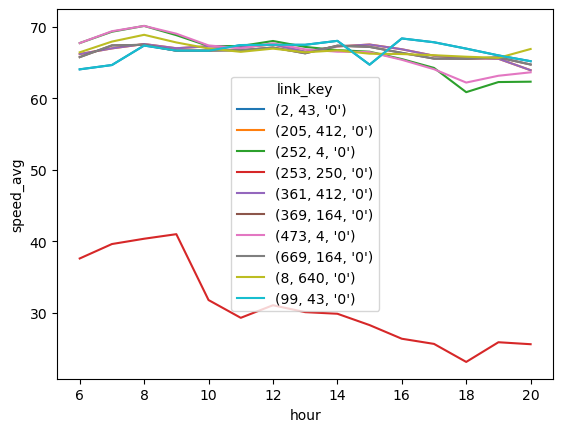

In [23]:
sns.lineplot(x= 'hour', y = 'speed_avg', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['speed_avg']].mean().reset_index())

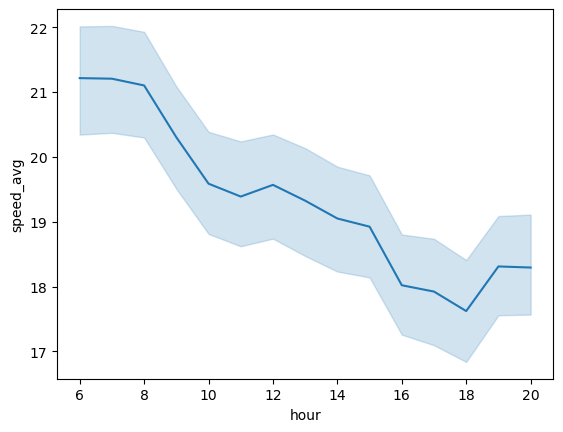

In [24]:
sns.lineplot(x= 'hour', y = 'speed_avg',
             data =eda_df.groupby(['hour','link_key'])[['speed_avg']].mean().reset_index())

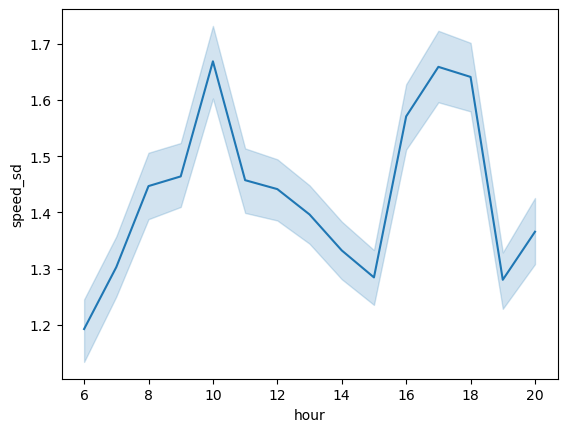

In [25]:
sns.lineplot(x= 'hour', y = 'speed_sd',
             data =eda_df.groupby(['hour','link_key'])[['speed_sd']].mean().reset_index())

## Training and validation sets

In [26]:
for year in sorted(df['year'].unique()):
    df_year = df[df['year'] == year].sort_values('period')

    n_timepoints = len(df_year.period.unique())

    traveltime_data = get_y_tensor(y=df_year[['tt_avg']], n_links=n_links, n_timepoints=n_timepoints)
    flow_data = get_y_tensor(y=df_year[['counts']], n_links=n_links, n_timepoints=n_timepoints)

    Y[year] = tf.concat([traveltime_data, flow_data], axis=2)

    X[year] = get_design_tensor(Z=df_year[features_Z+['period_id']], n_links=n_links, n_timepoints=n_timepoints)

    tt_ff = get_design_tensor(Z=df_year[['tt_ff']], n_links=n_links, n_timepoints=n_timepoints)

2022-11-01 15:07:59.077884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
# Prepare the training and validation dataset

# X = X[2019]
# Y = Y[2019]

# X_train, X_test, Y_train, Y_test = temporal_split(X[2019].numpy(), Y[2019].numpy(), n_days = X[2019].shape[0])

# X_train, X_test, Y_train, Y_test = X[2020], X[2019], Y[2020], Y[2019]
X_train, X_test, Y_train, Y_test = X[2019], X[2020], Y[2019], Y[2020]
# X_test, Y_test = None, None

## Network equilibrium predictor

In [28]:
equilibrator = Equilibrator(
    network=fresno_network,
    # paths_generator=paths_generator,
    utility=utility_parameters,
    max_iters=100,
    method='fw',
    iters_fw=50,
    accuracy=1e-4,
)

column_generator = ColumnGenerator(equilibrator=equilibrator,
                                   utility=utility_parameters,
                                   n_paths=0,
                                   ods_coverage=0.1,
                                   ods_sampling='sequential',
                                   # ods_sampling='demand',
                                   )

## Configuration

In [29]:
# _EPOCHS = {'learning': 6, 'equilibrium': 10}
_EPOCHS = {'learning': 100, 'equilibrium': 10}
# _EPOCHS = {'learning': 250, 'equilibrium': 50}
_BATCH_SIZE = 16
_LR = 5e-1
_RELATIVE_GAP = 1e-5
_XTICKS_SPACING = 50
_EPOCHS_PRINT_INTERVAL = 5

# Excluding historic OD gives more freedom for the model to find an equilibria and minimize reconstruction error
_LOSS_WEIGHTS ={'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1}

# _LOSS_METRIC  = mnrmse
# _MOMENTUM_EQUILIBRIUM = {'lue': 0.95, 'odlue': 0.95, 'odlulpe-1': 0.95, 'odlulpe-2': 0.95}

# NRMSE encourages a larger reduction in link flow loss and it does not requires to add much momentum to the equilibrium loss component
_LOSS_METRIC  = nrmse
_MOMENTUM_EQUILIBRIUM = {'lue': 0.99, 'odlue': 0.99, 'odlulpe-1': 0.99, 'odlulpe-2': 0.99,
                         'tvodlulpe':0.99}

# Including historic OD matrix
# _LOSS_WEIGHTS ={'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1}
# _MOMENTUM_EQUILIBRIUM = 0.99

# _LOSS_METRIC = mse
# _LOSS_WEIGHTS ={'od': 1, 'theta': 0, 'tt': 1e10, 'flow': 1, 'eq_flow': 1}

print(f"_LOSS_WEIGHTS: {_LOSS_WEIGHTS}, _MOMENTUM_EQUILIBRIUM: {_MOMENTUM_EQUILIBRIUM}, "
      f"epochs { _EPOCHS}")

_LOSS_WEIGHTS: {'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1}, _MOMENTUM_EQUILIBRIUM: {'lue': 0.99, 'odlue': 0.99, 'odlulpe-1': 0.99, 'odlulpe-2': 0.99, 'tvodlulpe': 0.99}, epochs {'learning': 100, 'equilibrium': 10}


## Models

In [30]:
run_model = dict.fromkeys(['equilibrium', 'lue', 'ode', 'odlue', 'odlulpe-1','odlulpe-2', 'tvodlulpe'], False)

run_model['lue'] = True
run_model['ode'] = True
run_model['odlue'] = True
run_model['odlulpe-1'] = True
run_model['odlulpe-2'] = True
run_model['tvodlulpe'] = True

In [31]:
train_results_dfs = {}
test_results_dfs = {}

### Model 2: Benchmark of gisuelogit and isuelogit


LUE: Benchmark of gisuelogit and isuelogit (utility only)

Epoch: 0/100, n_train: 52, n_test: 127

0: train_loss=2.2e+06, val_loss=1.8e+06, train_loss tt=3.8e-05, val_loss tt=3.5e-05, train_loss flow=2.2e+06, val_loss flow=1.8e+06, theta = [0. 0. 0. 0. 0. 0.], rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, lambda eq=1, relative x=1.8e-16, relative gap=1e-05, train flow equilibrium loss=1.1e-25, time: 46.9

Epoch: 1/100, n_train: 52, n_test: 127

1: train_loss=8.4e+05, val_loss=7.2e+05, train_loss tt=3.6e-05, val_loss tt=3.3e-05, train_loss flow=2.2e+06, val_loss flow=1.8e+06, theta = [-0.499 -0.499  0.    -0.5   -0.5   -0.5  ], rr = 1.00, psc_factor = 0.0, avg theta fixed effect = -0.0067, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, lambda eq=0.34, relative x=0.22, relative gap=12, train flow equilibrium loss=3.4e+05, time: 61.4

Epoch: 5/100, n_train: 52, n_test: 127

5: train_loss=7.6e+05, val_loss=6.4e+05, train_loss tt

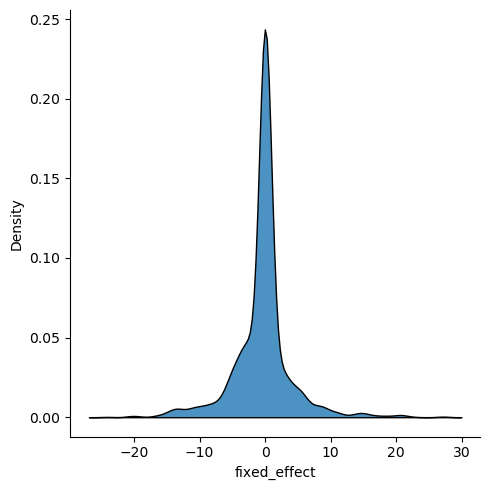

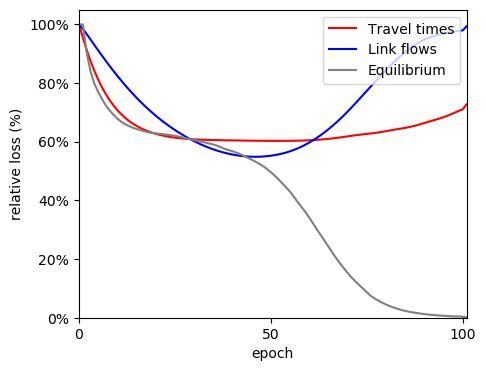

In [32]:
if run_model['lue']:
    print('\nLUE: Benchmark of gisuelogit and isuelogit (utility only)')

    # _MOMENTUM_EQUILIBRIUM = 1

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           # initial_values ={'tt': -1, 'tt_sd': -1, 'median_inc': 1,
                                           #                  'incidents': -1, 'bus_stops': -1, 'intersections': -1,
                                           #                  'psc_factor': 0, 'fixed_effect': np.zeros_like(fresno_network.links)},
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True, 'incidents': True,
                                                              'bus_stops': True, 'intersections': True
                                                       },
                                           )

    utility_parameters.constant_initializer(0)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 true_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=False)

    equilibrator = Equilibrator(
        network=fresno_network,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       )

    lue = GISUELOGIT(
        key='lue',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator = equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters
    )

    train_results_dfs['lue'], test_results_dfs['lue'] = lue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        threshold_relative_gap=_RELATIVE_GAP,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM['lue'],
        loss_weights= dict(_LOSS_WEIGHTS, od = 0),
        loss_metric=_LOSS_METRIC,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    sns.displot(pd.DataFrame({'fixed_effect':np.array(lue.fixed_effect)}),
            x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    plot_predictive_performance(train_losses=train_results_dfs['lue'], val_losses=test_results_dfs['lue'],
                                xticks_spacing = _XTICKS_SPACING)


    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}")
    print(f"alpha = {lue.alpha: 0.2f}, beta  = {lue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 3: OD + utility estimation with historic OD

In [33]:
if run_model['odlue']:

    # _MOMENTUM_EQUILIBRIUM = 0.99

    print('\nODLUE: OD + utility estimation with historic OD')

    # _RELATIVE_GAP = 1e-4\
    # _XTICKS_SPACING = 50

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)
    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)
    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlue = GISUELOGIT(
        key='odlue',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlue'], test_results_dfs['odlue'] = odlue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        # generalization_error={'train': False, 'validation': True},
        loss_weights= _LOSS_WEIGHTS,
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM['odlue'],
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['odlue'], val_losses=test_results_dfs['odlue'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['odlue'].\
                           assign(rr = train_results_dfs['odlue']['tt_sd']/train_results_dfs['odlue']['tt'])[['epoch','rr']],
                               xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.DataFrame({'fixed_effect':np.array(odlue.fixed_effect)}),
            x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}")
    print(f"alpha = {odlue.alpha: 0.2f}, beta  = {odlue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")


ODLUE: OD + utility estimation with historic OD

Epoch: 0/100, n_train: 52, n_test: 127

0: train_loss=2.2e+06, val_loss=1.8e+06, train_loss tt=3.8e-05, val_loss tt=3.5e-05, train_loss flow=2.2e+06, val_loss flow=1.8e+06, theta = [0. 0. 0. 0. 0. 0.], rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, lambda eq=1, relative x=1.8e-16, relative gap=1e-05, train flow equilibrium loss=1.1e-25, time: 51.6

Epoch: 1/100, n_train: 52, n_test: 127

1: train_loss=8.6e+05, val_loss=7.3e+05, train_loss tt=3.6e-05, val_loss tt=3.3e-05, train_loss flow=2.2e+06, val_loss flow=1.8e+06, theta = [-0.499 -0.499  0.    -0.5   -0.5   -0.5  ], rr = 1.00, psc_factor = 0.0, avg theta fixed effect = -0.0067, avg alpha=0.15, avg beta=4, loss demand=5, lambda eq=0.34, relative x=0.26, relative gap=12, train flow equilibrium loss=3.9e+05, time: 65.7

Epoch: 5/100, n_train: 52, n_test: 127

5: train_loss=7.4e+05, val_loss=6.3e+05, train_loss tt=3.1e-05, val_lo

KeyboardInterrupt: 

In [ ]:
plot_convergence_estimates(estimates=train_results_dfs['odlue'].\
                           assign(rr = train_results_dfs['odlue']['tt_sd']/train_results_dfs['odlue']['tt'])[['epoch','rr']])

In [ ]:
train_results_dfs['odlue']['tt_sd']/train_results_dfs['odlue']['tt']

### Model 4: ODLUE + link specific performance parameters (only alphas)

In [ ]:
if run_model['odlulpe-1']:

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alpha)')

    # _MOMENTUM_EQUILIBRIUM = 0.99

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # _LR = 1e-2
    # _RELATIVE_GAP = 1e-5
    # _XTICKS_SPACING = 50

    # Some initializations of the bpr parameters, makes the optimization to fail (e.g. alpha =1, beta = 1). Using a common
    # alpha but different betas for every link make the estimation more stable but there is overfitting after a certain amount of iterations

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   # initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                   #                 'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15,
                                   #                 'beta': 4 * np.ones_like(fresno_network.links, dtype=np.float32)},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta':False},
                                   # trainables={'alpha': True, 'beta': True},
                                   # trainables={'alpha': False, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'psc_factor': 0, 'tt':0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlulpe_1 = GISUELOGIT(
        key='odlulpe-1',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlulpe-1'], test_results_dfs['odlulpe-1'] = odlulpe_1.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights=_LOSS_WEIGHTS,
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM['odlulpe-1'],
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['odlulpe-1'], val_losses=test_results_dfs['odlulpe-1'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe-1'][['epoch','alpha']],
                                xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.DataFrame({'alpha':odlulpe_1.alpha}),
            x="alpha", multiple="stack", kind="kde", alpha = 0.8)

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe-1'].\
                       assign(rr = train_results_dfs['odlulpe-1']['tt_sd']/train_results_dfs['odlulpe-1']['tt'])[['epoch','rr']],
                           xticks_spacing = _XTICKS_SPACING)


    sns.displot(pd.DataFrame({'fixed_effect':np.array(odlulpe_1.fixed_effect)}),
                x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_1.theta.numpy())))}")
    print(f"alpha = {np.mean(odlulpe_1.alpha): 0.2f}, beta  = {np.mean(odlulpe_1.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_1.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

    ### Model 5: ODLUE + link specific performance parameters (alphas and betas)

In [ ]:
if run_model['odlulpe-2']:

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)')

    # _MOMENTUM_EQUILIBRIUM = 0.99

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # _LR = 5e-1
    # _RELATIVE_GAP = 1e-5

    # Some initializations of the bpr parameters, makes the optimization to fail (e.g. alpha =1, beta = 1). Using a common
    # alpha but different betas for every link make the estimation more stable but there is overfitting after a certain amount of iterations

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   # initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                   #                 'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15,
                                   #                 'beta': 4 * np.ones_like(fresno_network.links, dtype=np.float32)},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # trainables={'alpha': True, 'beta':False},
                                   trainables={'alpha': True, 'beta': True},
                                   # trainables={'alpha': False, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'psc_factor': 0, 'tt':0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlulpe_2 = GISUELOGIT(
        key='odlulpe-2',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlulpe-2'], test_results_dfs['odlulpe-2'] = odlulpe_2.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        # loss_weights={'od': 1, 'theta': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1},
        loss_weights=_LOSS_WEIGHTS,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM['odlulpe-2'],
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        loss_metric=_LOSS_METRIC,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['odlulpe-2'], val_losses=test_results_dfs['odlulpe-2'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe-2'][['epoch','alpha','beta']],
                                xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.melt(pd.DataFrame({'alpha':odlulpe_2.alpha, 'beta': odlulpe_2.beta}), var_name = 'parameters'),
                x="value", hue="parameters", multiple="stack", kind="kde", alpha = 0.8)

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe-2'].\
                       assign(rr = train_results_dfs['odlulpe-2']['tt_sd']/train_results_dfs['odlulpe-2']['tt'])[['epoch','rr']],
                           xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.DataFrame({'fixed_effect':np.array(odlulpe_2.fixed_effect)}),
                x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_2.theta.numpy())))}")
    print(f"alpha = {np.mean(odlulpe_2.alpha): 0.2f}, beta  = {np.mean(odlulpe_2.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_2.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

In [ ]:
if run_model['tvodlulpe']:
    print('\ntvodlulpe: Time specific utility and OD, link performance parameters, no historic OD')

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True},
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   trainables={'alpha': True, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 true_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    tvodlulpe = GISUELOGIT(
        key='tvodlulpe',
        network=fresno_network,
        dtype=tf.float64,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
        n_periods = len(np.unique(X_train[:,:,-1].numpy().flatten()))
    )

    train_results_dfs['tvodlulpe'], test_results_dfs['tvodlulpe'] = tvodlulpe.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights= _LOSS_WEIGHTS,
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium=_MOMENTUM_EQUILIBRIUM['tvodlulpe'],
        threshold_relative_gap=_RELATIVE_GAP,
        epochs=_EPOCHS)

    # Plot heatmap with flows of top od pairs
    plot_top_od_flows_periods(tvodlulpe, df, period_feature='hour', top_k=20)

    plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=test_results_dfs['tvodlulpe'],
                               xticks_spacing=_XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                               xticks_spacing=_XTICKS_SPACING)

    sns.displot(pd.melt(pd.DataFrame({'alpha':tvodlulpe.alpha, 'beta': tvodlulpe.beta}), var_name = 'parameters'),
                x="value", hue="parameters", multiple="stack", kind="kde", alpha = 0.8)

    plt.show()

    # Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
    theta_df = plot_utility_parameters_periods(tvodlulpe, df, period_feature='hour')

    plt.show()

    rr_df = theta_df.apply(compute_rr, axis=1).reset_index().rename(columns={'index': 'hour', 0: 'rr'})

    sns.lineplot(data=rr_df, x='hour', y="rr")

    plt.show()

    sns.displot(pd.DataFrame({'fixed_effect': np.array(tvodlulpe.fixed_effect)}),
                x="fixed_effect", multiple="stack", kind="kde", alpha=0.8)

    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(tvodlulpe.theta.numpy())))}")
    print(f"alpha = {np.mean(tvodlulpe.alpha): 0.2f}, beta  = {np.mean(tvodlulpe.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(tvodlulpe.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

## Write csv file with estimation results

In [ ]:
train_results_df, test_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, test_results_dfs])

network_name = 'Fresno'

train_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{network_name}.csv"
test_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{network_name}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
test_results_df.to_csv(f"./output/tables/{test_filename}")
print(f'File {test_filename} was written')

## Summary of models parameters

In [34]:
models = [lue,odlue,odlulpe_1,odlulpe_2, tvodlulpe]
results = pd.DataFrame({'parameter': [], 'model': []})

for model in models:
    results = results.append(pd.DataFrame(
        {'parameter': ['tt'] + features_Z +
                      ['rr'] +
                      ['fixed_effect_mean', 'fixed_effect_std',
                       'alpha_mean', 'alpha_std',
                       'beta_mean', 'beta_std',
                       'od_mean', 'od_std',],
         'values': list(np.mean(model.theta.numpy(),axis =0))  +
                   [float(model.get_parameters_estimates().eval('tt_sd/tt'))] +
                   [np.mean(model.fixed_effect),np.std(model.fixed_effect),
                    np.mean(model.alpha),np.std(model.alpha),
                    np.mean(model.beta),np.std(model.beta),
                    np.mean(model.q),np.std(model.q)]}).\
                             assign(model = model.key)
                             )

NameError: name 'odlulpe_1' is not defined

In [ ]:
results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4)

## Summary of models goodness of fit

In [ ]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_tt', 'loss_eq_flow', 'loss_total']

for i, model in enumerate(models):

    results_losses_model = model.split_results(train_results_dfs[model.key])[1].assign(model = model.key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = results_losses.append(results_losses_model)

results_losses[loss_columns] = (results_losses[loss_columns]-1)*100

In [ ]:
results_losses[['model'] + loss_columns].round(1)

## Plot of convergence toward true rr across models

In [ ]:
models = [lue,odlue,odlulpe_1,odlulpe_2, tvodlulpe]

train_estimates = {}
train_losses = {}

for model in models:
    train_estimates[model.key], train_losses[model.key] = model.split_results(results=train_results_dfs[model.key])

    train_estimates[model.key]['model'] = model.key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd']/train_estimates_df['tt']

estimates = train_estimates_df[['epoch','model','rr']].reset_index().drop('index',axis = 1)
estimates = estimates[estimates.epoch != 0]

fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

ax.set_ylabel('reliability ratio')

plt.ylim(ymin=0)

plt.show()